# Setup and load in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data (replace 'file.csv' with your actual file path)
complete_df = pd.read_csv('Resources/cleaned_completed_data.csv')

# Convert 'Date' column to datetime format
complete_df['date'] = pd.to_datetime(complete_df['date'], errors='coerce')

# Display the results
complete_df.head()

,date,index_sa,redfin_hpi_mom,case_shiller_index_mom,period_duration,region_type,table_id,is_seasonally_adjusted,region,state,...,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,30_year_%,price_drops_is_blank,price_drops_mom_is_blank,price_drops_yoy_is_blank
0,2012-01-01,59.9,0.0,-0.000005,30,state,23,False,Oklahoma,Oklahoma,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
1,2012-01-01,59.9,0.0,-0.000005,30,state,10,False,New Hampshire,New Hampshire,...,0.000000,0.000000,0.0,0.007093,0.000006,-0.000002,3.915,True,True,True
2,2012-01-01,59.9,0.0,-0.000005,30,state,42,False,Virginia,Virginia,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.915,True,True,True
3,2012-01-01,59.9,0.0,-0.000005,30,state,47,False,Michigan,Michigan,...,0.000000,0.000000,0.0,0.013045,-0.000005,0.000007,3.915,True,True,True
4,2012-01-01,59.9,0.0,-0.000005,30,state,12,False,New Jersey,New Jersey,...,0.000549,0.000005,0.0,0.007897,0.000018,0.000061,3.915,False,False,True


In [3]:
# Extract the year and calculate yearly averages
yearly_avg = complete_df.groupby(complete_df['date'].dt.year)['median_list_price'].mean().reset_index()

# Rename columns for clarity
yearly_avg.columns = ['Year', 'Median List Price']

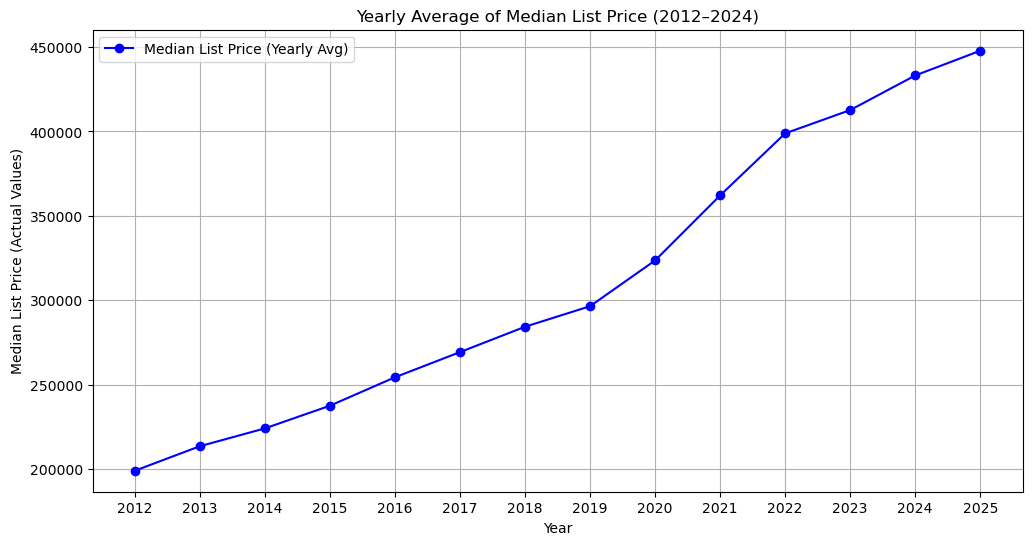

In [4]:
# Plot yearly averages of median_list_price
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['Year'], yearly_avg['Median List Price'], marker='o', color='blue', label='Median List Price (Yearly Avg)')

# Customize the chart
plt.xlabel('Year')
plt.ylabel('Median List Price (Actual Values)')
plt.title('Yearly Average of Median List Price (2012–2024)')
plt.legend()
plt.grid(True)

# Set xticks to include every year in the range
plt.xticks(yearly_avg['Year'])

# Show the plot
plt.show()

In [5]:
# Convert categorical columns using one-hot encoding
complete_df = pd.get_dummies(complete_df, columns=['region_type', 'is_seasonally_adjusted', 
                                                   'region', 'state', 'property_type'], drop_first=True)

In [6]:
# Select numeric columns from the DataFrame
numeric_df = complete_df.select_dtypes(include=[np.number])

# Show the min and max values for all columns
for col in numeric_df.columns:
    print(f"{col}: Min = {numeric_df[col].min()}, Max = {numeric_df[col].max()}")

index_sa: Min = 59.9, Max = 172.1
redfin_hpi_mom: Min = -0.0012, Max = 0.019
case_shiller_index_mom: Min = -6.97e-05, Max = 0.000189
period_duration: Min = 30, Max = 30
table_id: Min = 1, Max = 51
median_sale_price: Min = 7000, Max = 3275000
median_sale_price_mom: Min = -0.00913, Max = 0.2215270935960591
median_sale_price_yoy: Min = -0.0094134677419354, Max = 0.1257142857142857
median_list_price: Min = 53000.0, Max = 4700000.0
median_list_price_mom: Min = -0.0074388387547208, Max = 0.0357864417134923
median_list_price_yoy: Min = -0.0072507525002704, Max = 0.0363052617609819
median_ppsf: Min = 3.0, Max = 40906.0
median_ppsf_mom: Min = -0.0099740143148445, Max = 3.12172894350185
median_ppsf_yoy: Min = -0.0099760368452768, Max = 2.4325566423457765
median_list_ppsf: Min = 27.0, Max = 1873.0
median_list_ppsf_mom: Min = -0.0095540224646076, Max = 0.201536630306659
median_list_ppsf_yoy: Min = -0.0094918034612375, Max = 0.2102027881762564
homes_sold: Min = 1, Max = 53605
homes_sold_mom: Min = 

In [7]:
# Fill any missing values with the mean
complete_df = complete_df.fillna(complete_df.mean())

# Confirm completed
complete_df.isnull().sum()

date                                       0
index_sa                                   0
redfin_hpi_mom                             0
case_shiller_index_mom                     0
period_duration                            0
                                          ..
state_Wyoming                              0
property_type_Condo/Co-op                  0
property_type_Multi-Family (2-4 Unit)      0
property_type_Single Family Residential    0
property_type_Townhouse                    0
Length: 156, dtype: int64

## Preprocessing

In [8]:
# Inspect 'median_ppsf' due to large range

# Define bins in increments of $0–75
bins = np.arange(0, numeric_df['median_ppsf'].max() + 75, 75)
labels = [f"${int(b)}-${int(b + 75)}" for b in bins[:-1]]

# Bin the 'median_ppsf' column
numeric_df['median_ppsf_bin'] = pd.cut(numeric_df['median_ppsf'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
bin_counts = numeric_df['median_ppsf_bin'].value_counts().sort_index()

# Display the counts
bin_counts.head(25)

median_ppsf_bin
$0-$75          3668
$75-$150       18662
$150-$225       9250
$225-$300       3680
$300-$375       1449
$375-$450        974
$450-$525        635
$525-$600        357
$600-$675        133
$675-$750        112
$750-$825         44
$825-$900         16
$900-$975         10
$975-$1050        14
$1050-$1125        7
$1125-$1200       11
$1200-$1275        2
$1275-$1350        4
$1350-$1425        7
$1425-$1500        3
$1500-$1575        0
$1575-$1650        2
$1650-$1725        1
$1725-$1800        0
$1800-$1875        1
Name: count, dtype: int64

In [9]:
# Taking the bin_counts find the highest 25 'median_ppsf' values

# Sort the median_ppsf column in descending order and find the top 5 highest values
top_25_values = numeric_df['median_ppsf'].sort_values(ascending=False).head(25)

print("Highest 25 median_ppsf values:")
top_25_values

Highest 25 median_ppsf values:


38340    40906.0
8121     25964.0
6345     12690.0
16296     7214.0
21969     3790.0
3339      3672.0
1774      3140.0
19507     2712.0
31140     2504.0
14506     1996.0
16246     1957.0
9459      1918.0
3260      1839.0
22422     1720.0
8381      1645.0
16531     1576.0
2679      1468.0
17529     1463.0
2825      1457.0
6147      1409.0
29086     1406.0
15701     1395.0
3311      1393.0
9820      1375.0
22875     1371.0
Name: median_ppsf, dtype: float64

In [10]:
# Define bins for $100k increments
bins = np.arange(0, numeric_df['median_list_price'].max() + 100000, 100000)
labels = [f"${int(b)}-${int(b + 100000)}" for b in bins[:-1]]

# Bin the 'median_list_price' column
numeric_df['median_list_price_bin'] = pd.cut(numeric_df['median_list_price'], bins=bins, labels=labels, include_lowest=True)

# Count the occurrences in each bin
list_price_bin_counts = numeric_df['median_list_price_bin'].value_counts().sort_index()

# Display the counts
list_price_bin_counts

median_list_price_bin
$0-$100000              77
$100000-$200000       9697
$200000-$300000      14605
$300000-$400000       6954
$400000-$500000       3679
$500000-$600000       2118
$600000-$700000       1014
$700000-$800000        477
$800000-$900000        216
$900000-$1000000       104
$1000000-$1100000       27
$1100000-$1200000       16
$1200000-$1300000        7
$1300000-$1400000        5
$1400000-$1500000        1
$1500000-$1600000       10
$1600000-$1700000        4
$1700000-$1800000        2
$1800000-$1900000        2
$1900000-$2000000        7
$2000000-$2100000        4
$2100000-$2200000        5
$2200000-$2300000        4
$2300000-$2400000        5
$2400000-$2500000        1
$2500000-$2600000        4
$2600000-$2700000        1
$2700000-$2800000        0
$2800000-$2900000        2
$2900000-$3000000        2
$3000000-$3100000        1
$3100000-$3200000        0
$3200000-$3300000        1
$3300000-$3400000        0
$3400000-$3500000        0
$3500000-$3600000        0
$36000

In [11]:
# Set pandas to display floats as regular notation
pd.set_option('display.float_format', '{:.2f}'.format)

# Define limits
upper_limit_price = 1500000  
upper_limit_dom = 730        

# Apply filters to remove rows with outliers
filtered_df = complete_df[
    (complete_df['median_list_price'] <= upper_limit_price) & 
    (complete_df['median_dom'] <= upper_limit_dom)
]

# Verify the changes
print(filtered_df[['median_list_price', 'median_dom']].describe())

       median_list_price  median_dom
count           38944.00    38944.00
mean           301247.78       71.08
std            146271.35       52.15
min             53000.00        0.00
25%            200000.00       38.00
50%            260400.00       59.00
75%            362325.00       90.00
max           1491600.00      727.00


In [12]:
# Engineer interaction features
complete_df['price_per_sqft_ratio'] = complete_df['median_sale_price'] / complete_df['median_ppsf']
complete_df['inventory_to_sales_ratio'] = complete_df['inventory'] / complete_df['homes_sold']

# Handle cases where division might result in NaN or infinite values
complete_df['price_per_sqft_ratio'] = complete_df['price_per_sqft_ratio'].fillna(0).replace(np.inf, 0)
complete_df['inventory_to_sales_ratio'] = complete_df['inventory_to_sales_ratio'].fillna(0).replace(np.inf, 0)

## Split the data into training (1/1/2014 - 2/28/2013) and testing sets (3/1/23 - 9/30/2024) and define our target. `median_sales_price`.

In [13]:
# Split the dataset into training and testing sets based on the Date column
train_data = complete_df[(complete_df['date'] >= '2013-01-01') & (complete_df['date'] <= '2023-2-28')]
test_data = complete_df[(complete_df['date'] >= '2023-03-01') & (complete_df['date'] <= '2024-09-30')]

# Check the split
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows")

Training data: 30265 rows
Testing data: 4760 rows


In [14]:
# Drop redundant columns
columns_to_drop = ['case_shiller_index_mom', 'period_duration', 'table_id']  

# Define the train and test data
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [15]:
# Define the target variable (y)
y_train = train_data['median_sale_price']
y_test = test_data['median_sale_price']

# Define the features (X) by dropping only the target column 
X_train = train_data.drop(columns=['median_sale_price'])
X_test = test_data.drop(columns=['median_sale_price'])

print(X_train.columns == X_test.columns)  

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]


In [16]:
# Extract the date and target columns from the test data
test_target_with_date = test_data[['date', 'median_sale_price']]

# Save it to a CSV file
test_target_with_date.to_csv('Resources/target_data.csv', index=False)

print("Target set with date saved successfully!")

Target set with date saved successfully!


In [17]:
# load in the 'rf_optimized_1_results.csv'
test_results = pd.read_csv('Resources/rf_optimized_1_results.csv')

# Display results
test_results.head()

,Actual,Predicted,Difference
0,353000,354822.00,-1822.00
1,371400,371841.56,-441.56
2,243700,243554.42,145.58
3,612500,610418.00,2082.00
4,358700,358263.73,436.27


In [18]:
# Drop the 'median_sale_price' column from 'test_target_with_date'
test_target_with_date = test_target_with_date.drop(columns=['median_sale_price'])

# Merge 'test_target_with_date' with 'test_results' 
merged_results = pd.concat([test_target_with_date.reset_index(drop=True), test_results.reset_index(drop=True)], axis=1)

# Save the merged results to a CSV for further analysis or plotting
merged_results.to_csv('Resources/rf_test_results.csv', index=False)

print("Merged results saved successfully!")

Merged results saved successfully!


In [19]:
# Count the number of rows for each date
date_counts = merged_results['date'].value_counts().sort_index()

# Print the counts for each date
date_counts

date
2023-03-01    251
2023-04-01    250
2023-05-01    250
2023-06-01    252
2023-07-01    252
2023-08-01    252
2023-09-01    251
2023-10-01    253
2023-11-01    252
2023-12-01    251
2024-01-01    251
2024-02-01    250
2024-03-01    250
2024-04-01    248
2024-05-01    250
2024-06-01    250
2024-07-01    248
2024-08-01    248
2024-09-01    251
Name: count, dtype: int64

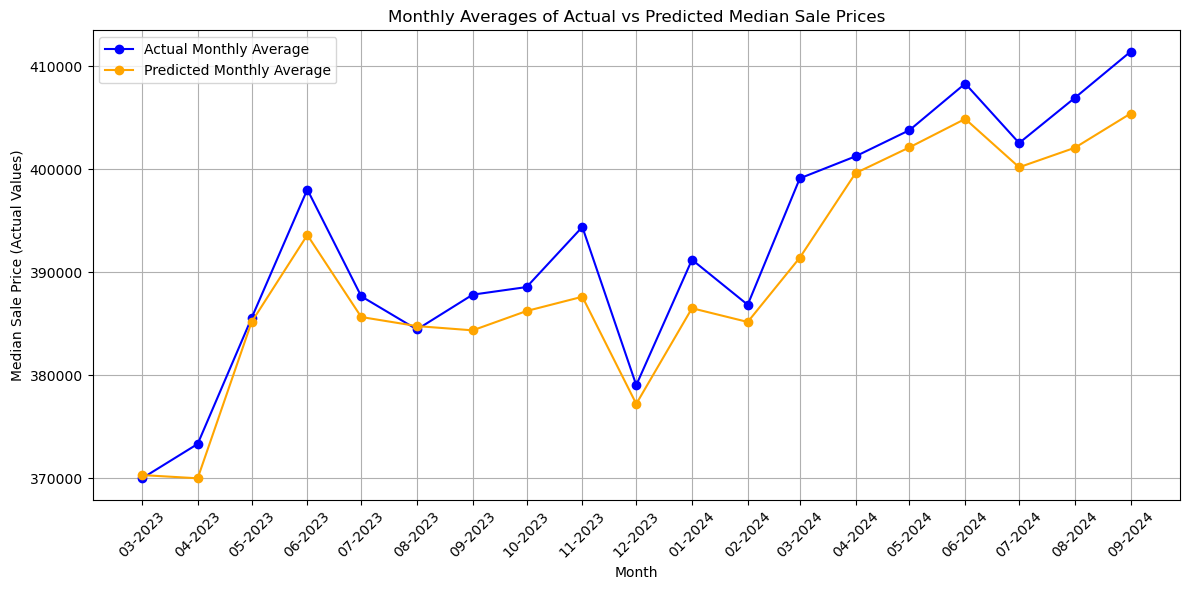

In [20]:
# Ensure the 'date' column is in datetime format
merged_results['date'] = pd.to_datetime(merged_results['date'])

# Group by month and calculate the average for Actual and Predicted
monthly_avg = merged_results.groupby(merged_results['date'].dt.to_period('M')).mean()

# Convert the Period Index back to datetime for plotting
monthly_avg.index = monthly_avg.index.to_timestamp()

# Plot the monthly averages
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual Monthly Average', marker='o', color='blue')
plt.plot(monthly_avg.index, monthly_avg['Predicted'], label='Predicted Monthly Average', marker='o', color='orange')

# Add titles and labels
plt.title('Monthly Averages of Actual vs Predicted Median Sale Prices')
plt.xlabel('Month')
plt.ylabel('Median Sale Price (Actual Values)')
plt.legend()
plt.grid()

# Set xticks to include all measured dates
plt.xticks(monthly_avg.index, monthly_avg.index.strftime('%m-%Y'), rotation=45)

# Save the plot as an image
# plt.savefig('Resources/test_results_plot.png', format='png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

# print("Plot saved as 'Resources/test_results_plot.png'.")

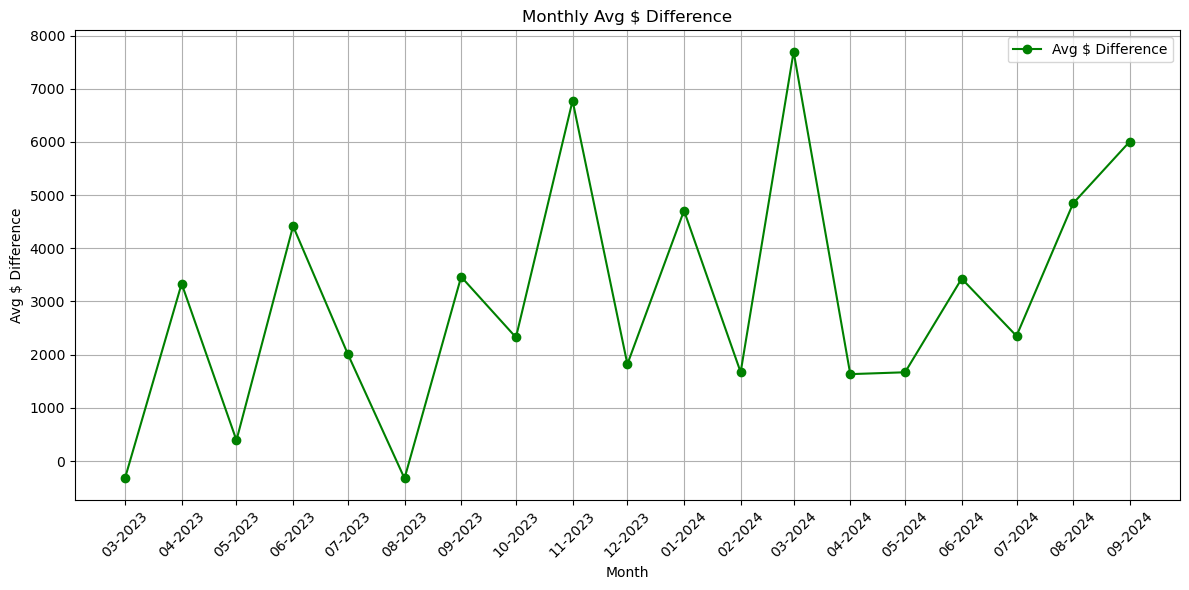

In [21]:
# Group by month and calculate the average Difference
monthly_difference_avg = merged_results.groupby(merged_results['date'].dt.to_period('M'))['Difference'].mean()

# Convert the PeriodIndex back to datetime for plotting
monthly_difference_avg.index = monthly_difference_avg.index.to_timestamp()

# Plot the monthly averages of Difference
plt.figure(figsize=(12, 6))
plt.plot(monthly_difference_avg.index, monthly_difference_avg, label='Avg $ Difference', marker='o', color='green')

# Add titles and labels
plt.title('Monthly Avg $ Difference')
plt.xlabel('Month')
plt.ylabel('Avg $ Difference')
plt.grid()
plt.xticks(monthly_difference_avg.index, monthly_difference_avg.index.strftime('%m-%Y'), rotation=45)
plt.legend()

# Save the plot as a PNG
plt.tight_layout()
# plt.savefig('Resources/monthly_difference_plot.png', format='png', dpi=300)

# Show the plot
plt.show()

# print("Plot saved as 'Resources/monthly_difference_plot.png'.")


## Load in the saved `final_rf_model` and re-run on the training and testing data set and make predictions for future years.

In [25]:
# from joblib import load

# Load the model 'rf_optimized_1.ipynb' 
# loaded_model = load('Resources/final_rf_model.joblib')

# print("Model loaded successfully!")

In [23]:
# Establish the model from prior notebook saved
loaded_model = RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [26]:
# Drop the 'date' column from X_train and X_test
X_train = X_train.drop(columns=['date'], errors='ignore')
X_test = X_test.drop(columns=['date'], errors='ignore')

print("Dropped 'date' column from X_train and X_test successfully!")

Dropped 'date' column from X_train and X_test successfully!


In [27]:
# Fit the model with the cleaned training data
loaded_model.fit(X_train, y_train)

# Evaluate the model using X_test
test_predictions = loaded_model.predict(X_test)

In [28]:
# Calculate the results of first test
r2 = r2_score(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)

print(f"Model Performance for the: R^2 Score: {r2:.4f}")
print(f"Model Performance for the: Mean Squared Error: {mse:.4f}")
print(f"Model Performance for the: Mean Absolute Error: {mae:.4f}")

Model Performance for the: R^2 Score: 0.9456
Model Performance for the: Mean Squared Error: 2123880209.8775
Model Performance for the: Mean Absolute Error: 8831.4701


In [29]:
# Calculate the top 25 features and sort in descending order
importances = loaded_model.feature_importances_ 
feature_names = X_train.columns
sorted_indices = importances.argsort()[::-1]  

top_25_features = feature_names[sorted_indices][:25]  
top_25_features

Index(['median_list_price', 'price_per_sqft_ratio', 'median_list_ppsf',
       'median_ppsf', 'median_sale_price_yoy', 'index_sa',
       'median_sale_price_mom', 'property_type_Condo/Co-op', 'inventory',
       'pending_sales', 'inventory_yoy', 'median_ppsf_mom', 'inventory_mom',
       'median_ppsf_yoy', 'avg_sale_to_list_yoy', 'new_listings', 'homes_sold',
       'homes_sold_mom', 'median_dom', 'off_market_in_two_weeks_mom',
       'avg_sale_to_list', 'median_list_ppsf_yoy',
       'off_market_in_two_weeks_yoy', 'median_dom_yoy',
       'median_list_ppsf_mom'],
      dtype='object')

In [31]:
# Reset pandas display to show floats with six decimal places due to small values
pd.options.display.float_format = '{:.6f}'.format

# Create a DataFrame for the top 25 features and their importance scores
top_25_importance_df = pd.DataFrame({
    'Feature': top_25_features,  # Your top 25 features list
    'Importance': importances[sorted_indices][:25]  # Corresponding importance scores
})

# Sort by importance scores (descending order) for clarity
top_25_importance_df = top_25_importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
top_25_importance_df

,Feature,Importance
0,median_list_price,0.610466
1,price_per_sqft_ratio,0.143681
2,median_list_ppsf,0.109319
3,median_ppsf,0.102004
4,median_sale_price_yoy,0.007327
5,index_sa,0.004327
6,median_sale_price_mom,0.003794
7,property_type_Condo/Co-op,0.001403
8,inventory,0.001306
9,pending_sales,0.001092


In [32]:
# Redefine X_train and X_test using the top_25_features
X_train_top25 = X_train[top_25_features]
X_test_top25 = X_test[top_25_features]

In [33]:
# Re-fit the model on the training data
loaded_model.fit(X_train_top25, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [34]:
# Use the model to predict on the test data
y_pred_top25 = loaded_model.predict(X_test_top25)

In [35]:
# Evaluate the model
mse_top25 = mean_squared_error(y_test, y_pred_top25)
mae_top25 = mean_absolute_error(y_test, y_pred_top25)
r2_top25 = r2_score(y_test, y_pred_top25)

# Print the results
print(f"Top 25 Mean Squared Error: {mse_top25}")
print(f"Top 25 Mean Absolute Error: {mae_top25}")
print(f"Top 25 R² Score: {r2_top25}")

Top 25 Mean Squared Error: 2060469184.849252
Top 25 Mean Absolute Error: 8304.063274053642
Top 25 R² Score: 0.9472355289322844


In [36]:
# Recheck addtl parameters model
# Defiine the model
optimized_model = RandomForestRegressor(max_depth=20, min_samples_leaf=1, 
                                        min_samples_split=2, n_estimators=300, 
                                        random_state=42, n_jobs=-1)

In [37]:
# Redefine X_train and X_test using the top_25_features
X_train_top25 = X_train[top_25_features]
X_test_top25 = X_test[top_25_features]

In [38]:
# Re-fit the model on the training data
optimized_model.fit(X_train_top25, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [39]:
# Use the model to predict on the test data
y_pred_optimized = optimized_model.predict(X_test_top25)

In [40]:
# Evaluate the model
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)

# Print the results
print(f"Top 25 Mean Squared Error: {mse_optimized}")
print(f"Top 25 Mean Absolute Error: {mae_optimized}")
print(f"Top 25 R² Score: {r2_optimized}")

Top 25 Mean Squared Error: 2060469184.849252
Top 25 Mean Absolute Error: 8304.063274053642
Top 25 R² Score: 0.9472355289322844


In [42]:
# Need to add back the 'date' to resplit the training and testing

X_train_top25['date'] = complete_df.loc[X_train_top25.index, 'date']
X_test_top25['date'] = complete_df.loc[X_test_top25.index, 'date']

# Verify that the 'date' column is restored
print("Date column added back to X_train and X_test!")

Date column added back to X_train and X_test!


In [44]:
# Concat Training and Testing Data to make predictions on our (07/2024 - 09/2024)
X_test_hold = X_test_top25[(X_test_top25['date'] >= '2024-07-01') & (X_test_top25['date'] <= '2024-09-30')]
X_test_eval = X_test_top25[X_test_top25['date'] < '2024-07-01']

# Concatenate Training Data and Evaluation Test Data - exclude last 3 months
X_combined = pd.concat([X_train_top25, X_test_eval], axis=0)

# Confirm the dimensions
print(f"Shape of training + evaluation dataset: {X_combined.shape}")
print(f"Shape of withheld dataset: {X_test_hold.shape}")

Shape of training + evaluation dataset: (34278, 26)
Shape of withheld dataset: (747, 26)


In [45]:
# Define the model
final_model = RandomForestRegressor(max_depth=20, min_samples_leaf=1, 
                                    min_samples_split=2, n_estimators=300, 
                                    random_state=42, n_jobs=-1)

In [47]:
# Combine the target values for training and evaluation test data
y_combined = pd.concat([y_train, y_test[X_test_eval.index]], axis=0)

# Verify the shape matches X_combined
print(f"Shape of y_train_combined: {y_combined.shape}")
print(f"Shape of X_combined: {X_combined.shape}")

Shape of y_train_combined: (34278,)
Shape of X_combined: (34278, 26)


In [48]:
# Check if 'date' column exists in X_combined
if 'date' in X_combined.columns:
    # Remove the 'date' column
    X_combined = X_combined.drop(columns=['date'])
    print("'date' column has been removed.")
else:
    print("'date' column is not in X_combined.")

'date' column has been removed.


In [51]:
# Ensure the 'date' column is removed from X_test_hold
if 'date' in X_test_hold.columns:
    X_test_hold = X_test_hold.drop(columns=['date'])
    print("'date' column has been removed from X_test_hold.")
else:
    print("'date' column is not in X_test_hold.")

'date' column has been removed from X_test_hold.


In [49]:
# Fit the final_model and Train the model on the combined dataset
final_model.fit(X_combined, y_combined)

RandomForestRegressor(max_depth=20, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [52]:
# Make predictions on the withheld test data
y_pred_hold = final_model.predict(X_test_hold)

In [53]:
# True target values for the withheld dataset
y_true_hold = y_test.loc[X_test_hold.index]

# Evaluate performance
mse_hold = mean_squared_error(y_true_hold, y_pred_hold)
mae_hold = mean_absolute_error(y_true_hold, y_pred_hold)
r2_hold = r2_score(y_true_hold, y_pred_hold)

# Print the results
print(f"Mean Squared Error (Holdout): {mse_hold}")
print(f"Mean Absolute Error (Holdout): {mae_hold}")
print(f"R² Score (Holdout): {r2_hold}")


Mean Squared Error (Holdout): 2104697275.6909773
Mean Absolute Error (Holdout): 7051.7177115952245
R² Score (Holdout): 0.9526112229978853


In [58]:
# Create a DataFrame with true and predicted values
holdout_results = pd.DataFrame({
    'True_Values': y_test.loc[X_test_hold.index],
    'Predicted_Values': y_pred_hold
})

# Format Predicted_Values to 2 decimal places using .2f
holdout_results['Predicted_Values'] = holdout_results['Predicted_Values'].apply(lambda x: format(x, '.2f'))

# Preview the updated DataFrame
holdout_results.head()

,True_Values,Predicted_Values
32360,333900,339313.02
32361,1085100,957614.33
32362,251700,252739.67
32363,376500,378883.00
32364,286400,286150.23


In [60]:
# Retrieve the 'date' column from the original X_test_top25 using the indices of X_test_hold
holdout_results['Date'] = X_test_top25.loc[X_test_hold.index, 'date']

# Preview the updated DataFrame
holdout_results.head()

,True_Values,Predicted_Values,Date
32360,333900,339313.02,2024-07-01
32361,1085100,957614.33,2024-07-01
32362,251700,252739.67,2024-07-01
32363,376500,378883.00,2024-07-01
32364,286400,286150.23,2024-07-01


In [61]:
# Rename columns in the holdout_results DataFrame
holdout_results.rename(columns={'Date': 'date', 'True_Values': 'Actual', 'Predicted_Values': 'Predicted'}, inplace=True)

In [68]:
# Convert the 'Predicted' column to numeric format
holdout_results['Predicted'] = holdout_results['Predicted'].astype(float)

# Round 'Predicted' values to 2 decimal places
holdout_results['Predicted'] = holdout_results['Predicted'].round(2)

# Calculate the 'Difference' column (Actual - Predicted)
holdout_results['Difference'] = holdout_results['Actual'].astype(float) - holdout_results['Predicted']

# Preview the updated DataFrame
holdout_results.head()

,Actual,Predicted,date,Difference
32360,333900,339313.02,2024-07-01,-5413.02
32361,1085100,957614.33,2024-07-01,127485.67
32362,251700,252739.67,2024-07-01,-1039.67
32363,376500,378883.00,2024-07-01,-2383.00
32364,286400,286150.23,2024-07-01,249.77


In [69]:
# Move 'date' to the first column
columns_order = ['date'] + [col for col in holdout_results.columns if col != 'date']
holdout_results = holdout_results[columns_order]

# Preview the updated DataFrame
holdout_results.head()

,date,Actual,Predicted,Difference
32360,2024-07-01,333900,339313.02,-5413.02
32361,2024-07-01,1085100,957614.33,127485.67
32362,2024-07-01,251700,252739.67,-1039.67
32363,2024-07-01,376500,378883.00,-2383.00
32364,2024-07-01,286400,286150.23,249.77


In [70]:
# Save the results to a CSV file named 'the_model_results.csv'
holdout_results.to_csv('Resources/the_model_results.csv', index=False)

print("Results have been saved as 'the_model_results.csv'.")

Results have been saved as 'the_model_results.csv'.


In [71]:
holdout_results.dtypes

date          datetime64[ns]
Actual                 int64
Predicted            float64
Difference           float64
dtype: object

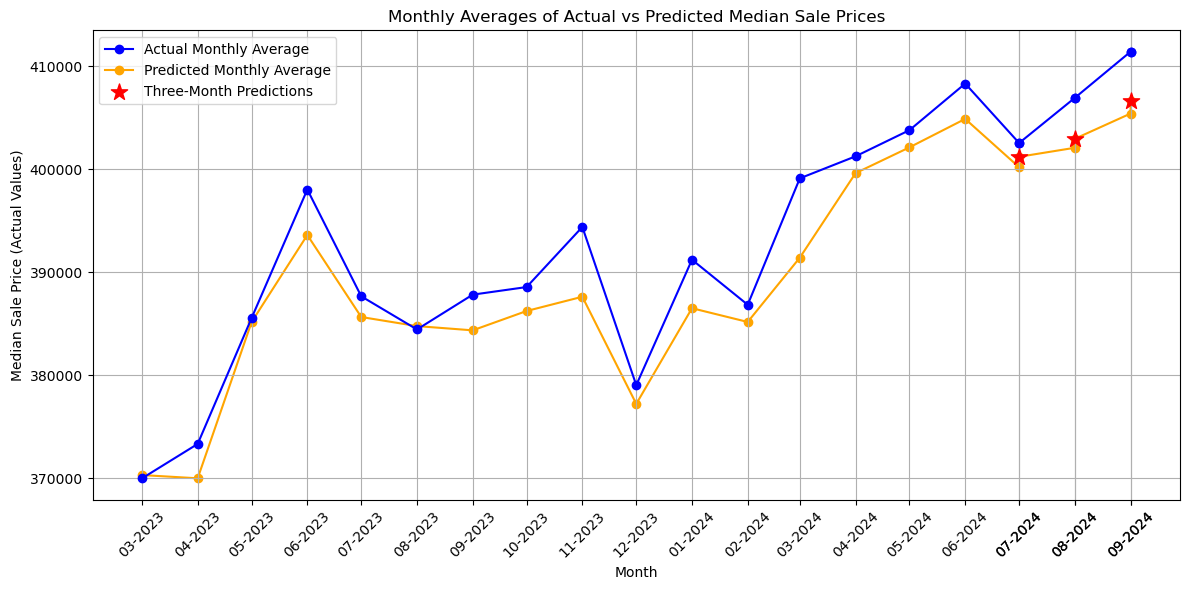

In [85]:
# Recreate the original Train and Test Results and add in our 3 month complete set test results from holdout_results
# Calculate monthly averages for Actual and Predicted values
# Plot all values
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg.index, monthly_avg['Actual'], label='Actual Monthly Average', marker='o', color='blue', zorder=2)
plt.plot(monthly_avg.index, monthly_avg['Predicted'], label='Predicted Monthly Average', marker='o', color='orange', zorder=1)

# Highlight 07/2024, 08/2024, and 09/2024 predictions from holdout_results in red
plt.scatter(three_month_avg.index, three_month_avg['Predicted'], label='Three-Month Predictions', color='red', s=150, marker='*', zorder=3)

# Add titles and labels
plt.title('Monthly Averages of Actual vs Predicted Median Sale Prices')
plt.xlabel('Month')
plt.ylabel('Median Sale Price (Actual Values)')
plt.legend()
plt.grid()

# Set xticks for all measured dates
plt.xticks(monthly_avg.index, monthly_avg.index.strftime('%m-%Y'), rotation=45)

# Save the plot as an image (optional)
plt.savefig('Resources/final_model_comparison.png', format='png', dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

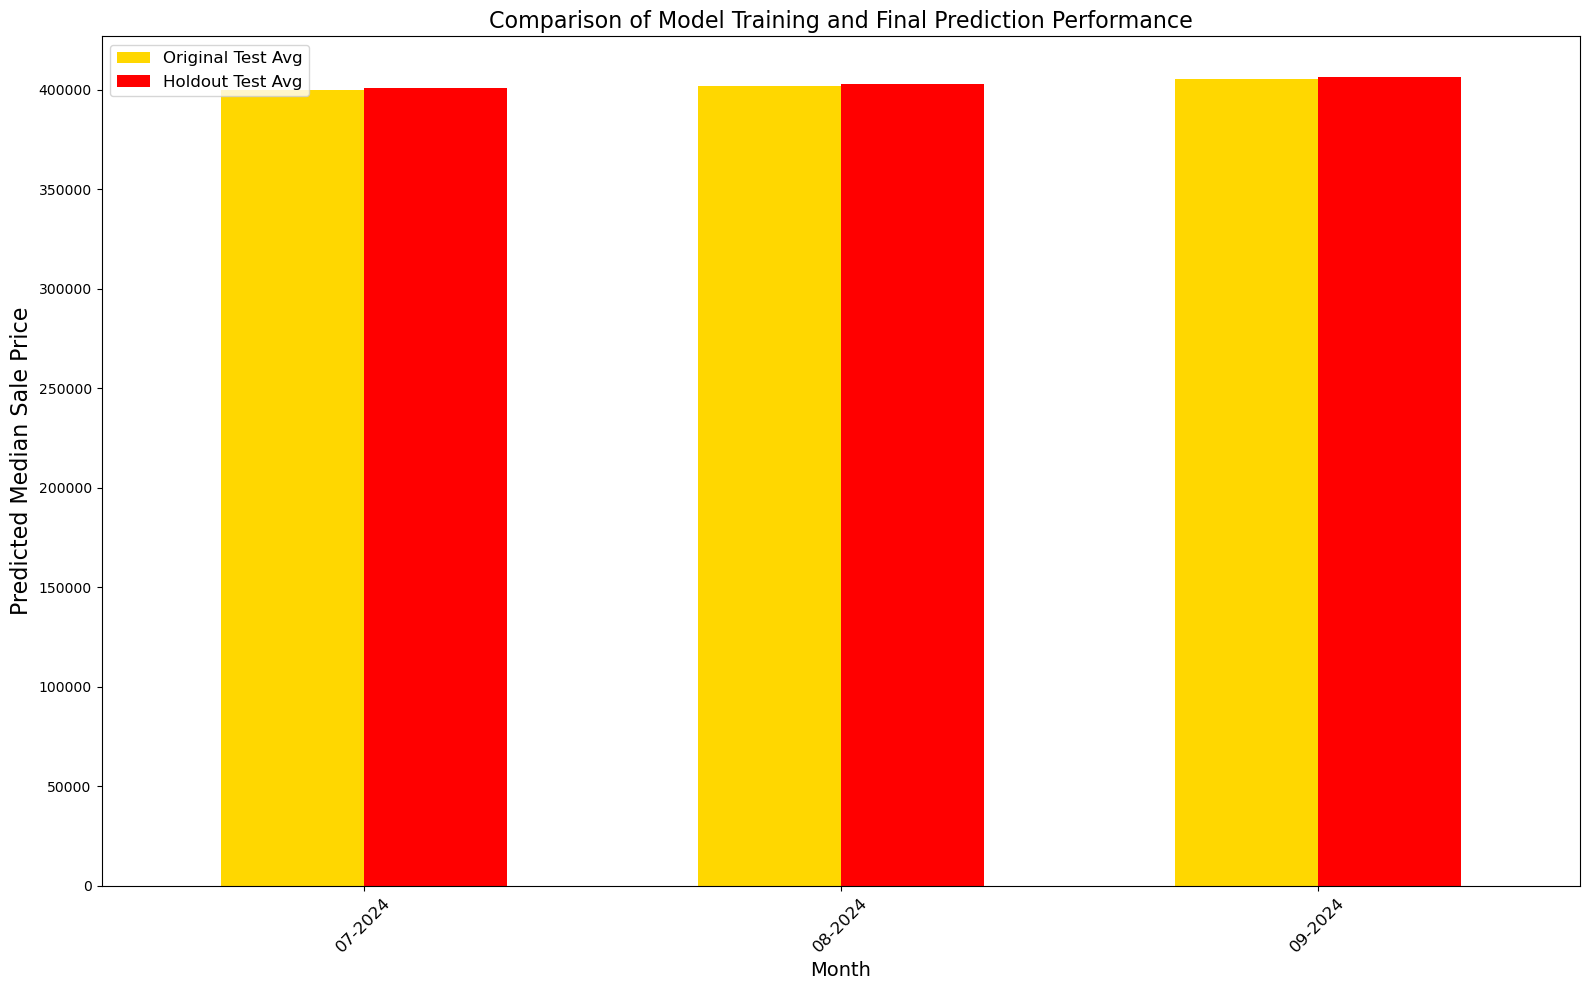

In [86]:
# Calculate averages for the original test results and holdout results
original_test_avg = merged_results.groupby(merged_results['date'].dt.to_period('M')).mean()
three_month_avg = holdout_results.groupby(holdout_results['date'].dt.to_period('M')).mean()

# Extract only the months of interest (07/2024, 08/2024, 09/2024)
comparison_months = ['2024-07', '2024-08', '2024-09']
original_test_avg = original_test_avg.loc[comparison_months]
three_month_avg = three_month_avg.loc[comparison_months]

# Convert the Period Index to datetime for consistent plotting
original_test_avg.index = original_test_avg.index.to_timestamp()
three_month_avg.index = three_month_avg.index.to_timestamp()

# Create a DataFrame for easy plotting
comparison_df = pd.DataFrame({
    'Original Test Avg': original_test_avg['Predicted'], 
    'Holdout Test Avg': three_month_avg['Predicted']
}, index=original_test_avg.index)

# Plot the comparison bar chart
plt.figure(figsize=(16, 10)) 
comparison_df.plot(kind='bar', color=['gold', 'red'], width=0.6, ax=plt.gca()) 

# Add labels, title, and legend
plt.title('Comparison of Model Training and Final Prediction Performance', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Predicted Median Sale Price', fontsize=16)  
plt.legend(['Original Test Avg', 'Holdout Test Avg'], loc='upper left', fontsize=12)

# Fix the x-ticks to show only the month and year
plt.xticks(ticks=range(len(comparison_df.index)),
           labels=comparison_df.index.strftime('%m-%Y'),
           rotation=45, fontsize=12)

# Improve layout spacing
plt.tight_layout()

# Save the bar chart as an image (optional)
plt.savefig('Resources/comparison_bar_chart.png', format='png', dpi=300)

# Show the plot
plt.show()


## Generate the top 25 feature columns and data from the datset to test model on future